### Initial settings

In [1]:
#-- Import general libraries
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices # Comment out this line if runing on GPU cluster
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{0}"

In [3]:
# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(f"Is GPU available? {is_gpu}")

# If GPU is available, print additional information
if is_gpu:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"GPU Device Name: {device_name}")
    print(f"GPU Device Index: {current_device}")

Is GPU available? True
GPU Device Name: GeForce RTX 2080 Ti
GPU Device Index: 0


#### Filters

In [4]:
# # # ################################### # # #
# # # ######   Numerial parameters ###### # # #
# # # ################################### # # #
c = 1  # speed of sound 1m/s
courant_number = 0.1

# # # ################################### # # #
# # # ######    Linear Filter      ###### # # #
# # # ################################### # # #




filter = torch.tensor([[0.0, -1.0, 0.0],
       [-1.0, 4.0, -1.0],
       [0.0, -1.0, 0.0]])



advection_operator_x = torch.tensor([[0.0, 0.0, 0.0],
       [0.5, 0.0, -0.5],
       [0.0, 0.0, 0.0]])

advection_operator_y = torch.tensor([[0.0, -0.5, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.5, 0.0]])

print(filter)
print(filter.shape)

tensor([[ 0., -1.,  0.],
        [-1.,  4., -1.],
        [ 0., -1.,  0.]])
torch.Size([3, 3])


##### 7*7 Cubic

In [5]:
# 7*7
data_str = """-1.0975826519729831E-003   6.6388197653750505E-003  -3.1874333451830800E-002   4.1414859580519367E-003  -3.1874333451830786E-002   6.6388197653750435E-003  -1.0975826519729816E-003
 6.6388197653750505E-003  -3.4553857092072565E-002  0.13605581230003569       0.18684678279416977       0.13605581230003563       -3.4553857092072537E-002   6.6388197653750418E-003
-3.1874333451830800E-002  0.13605581230003572      -0.35093761109136207       -2.0260398151439736      -0.35093761109136201       0.13605581230003563       -3.1874333451830779E-002
 4.1414859580518951E-003  0.18684678279416983       -2.0260398151439745        8.0000000000000000       -2.0260398151439745       0.18684678279416983        4.1414859580518951E-003
-3.1874333451830786E-002  0.13605581230003563      -0.35093761109136201       -2.0260398151439736      -0.35093761109136201       0.13605581230003569       -3.1874333451830800E-002
 6.6388197653750418E-003  -3.4553857092072537E-002  0.13605581230003563       0.18684678279416977       0.13605581230003566       -3.4553857092072565E-002   6.6388197653750505E-003
-1.0975826519729816E-003   6.6388197653750435E-003  -3.1874333451830779E-002   4.1414859580519367E-003  -3.1874333451830807E-002   6.6388197653750505E-003  -1.0975826519729831E-003"""

# Convert the string to a 2D NumPy array
data_array = np.array([list(map(float, line.split())) for line in data_str.split('\n')])

# Reshape the array into a 9x9 tensor
tensor = data_array.reshape(7, 7)

# Print the generated tensor
print(tensor)

filter = torch.FloatTensor(tensor*1)

print(filter.shape)

[[-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 4.14148596e-03  1.86846783e-01 -2.02603982e+00  8.00000000e+00
  -2.02603982e+00  1.86846783e-01  4.14148596e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]]
torch.Size([7, 7])


#### New initial conditions - Gaussian Distribution

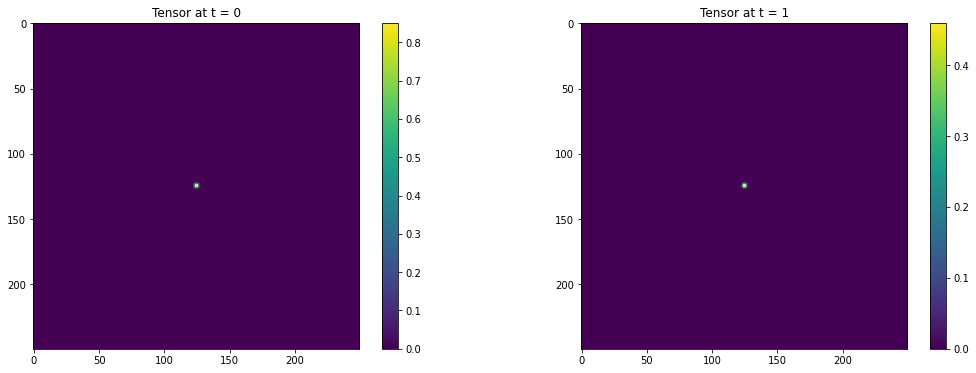

In [6]:
# Specify the size of the tensor
xysize = 250

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Plot the tensors
plt.figure(figsize=(18, 6))

# Plot at t = 0
plt.subplot(1, 2, 1)
plt.imshow(status_t0.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 0')
plt.colorbar()

# Plot at t = 1
plt.subplot(1, 2, 2)
plt.imshow(status_t1.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 1')
plt.colorbar()

# # Plot at t = 2
# plt.subplot(1, 3, 3)
# plt.imshow(status_t2.numpy(), cmap='viridis', interpolation='none')
# plt.title('Tensor at t = 2')
# plt.colorbar()

plt.show()

#### C spead of sound

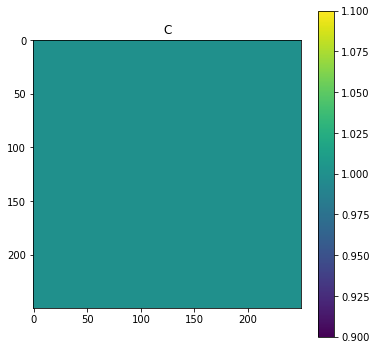

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')


In [7]:
c_np = np.ones((xysize, xysize))

# uncomment to make the values different
# right_half_start = xysize // 2
# c_np[:, right_half_start:] = 2

c = torch.from_numpy(c_np).float()

# Plot the tensor at t = 0
plt.figure(figsize=(6, 6))
plt.imshow(c.detach().numpy(), cmap='viridis', interpolation='none')
plt.title('C')
plt.colorbar()
plt.show()

c = c.to(device)
print(c)

In [8]:
del c


In [9]:
torch.cuda.empty_cache()

#### Sigma2

In [10]:
l = xysize/10

In [11]:
value_origin_point = - 9 * (4-0)
k = 400

In [12]:
sigma2 = torch.zeros((xysize, xysize), dtype=torch.float32)

In [13]:
l_over_speed = (l / 1) * 0.05 
print(l_over_speed)

1.25


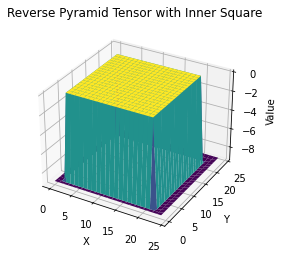

In [14]:
def create_reverse_pyramid_tensor(size, inner_square_ratio):
    pyramid = np.zeros((size, size), dtype=np.float32)

    center = size // 2
    center_value = -16.0/(l_over_speed*l_over_speed)
    boundary_value = 4.0/(l_over_speed*l_over_speed)

    inner_square_width = int(size * inner_square_ratio)

    for i in range(size):
        for j in range(size):
            distance_to_center = max(abs(i - center), abs(j - center))
            
            # Set the values for the reverse pyramid
            pyramid[i, j] = center_value + 4.0/(l_over_speed*l_over_speed) * (distance_to_center/xysize/0.1)
            
            # Set the values for the inner square to 0
            if (
                i >= center - inner_square_width // 2 and i < center + inner_square_width // 2
                and j >= center - inner_square_width // 2 and j < center + inner_square_width // 2
            ):
                pyramid[i, j] = 0.0

    return pyramid

# Set the size of the pyramid (choose an odd number for symmetry)
pyramid_size = 25  # xysize = 25
# inner_square_ratio = 9/10
inner_square_ratio = 4/5

# Create the reverse pyramid tensor with inner square values set to 0
sigma2 = create_reverse_pyramid_tensor(pyramid_size, inner_square_ratio)

# Plot the reverse pyramid tensor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, pyramid_size, 1)
y = np.arange(0, pyramid_size, 1)
x, y = np.meshgrid(x, y)

ax.plot_surface(x, y, sigma2, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
ax.set_title('Reverse Pyramid Tensor with Inner Square')

plt.show()

sigma2 = torch.from_numpy(sigma2).to(device)

tensor([[-9.0112, -9.0112, -9.0112, -9.0112, -9.0112, -9.0112, -9.0112, -9.0112,
         -9.0112, -9.0112, -9.0112, -9.0112, -9.0112, -9.0112, -9.0112, -9.0112,
         -9.0112, -9.0112, -9.0112, -9.0112, -9.0112, -9.0112, -9.0112, -9.0112,
         -9.0112],
        [-9.0112, -9.1136, -9.1136, -9.1136, -9.1136, -9.1136, -9.1136, -9.1136,
         -9.1136, -9.1136, -9.1136, -9.1136, -9.1136, -9.1136, -9.1136, -9.1136,
         -9.1136, -9.1136, -9.1136, -9.1136, -9.1136, -9.1136, -9.1136, -9.1136,
         -9.0112],
        [-9.0112, -9.1136,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -9.2160, -9.1136,
         -9.0112],
        [-9.0112, -9.1136,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000

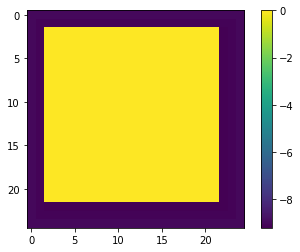

In [15]:
print(sigma2)
plt.imshow(sigma2.detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

#### ML

In [16]:
ML = torch.ones((1, 1, xysize, xysize), dtype=torch.float64)

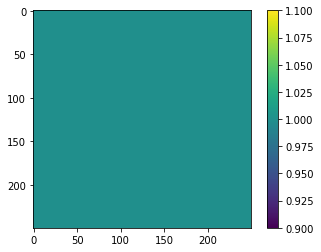

In [17]:
plt.imshow((ML/ML)[0][0].detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

### Define NN Model

#### one time step - skipping layers

In [18]:
# class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
#     def __init__(self, xysize, filter_weight):
#         super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

#         # Specify the size of the input (batch_size, channels, height, width)
#         in_channels = 1

#         # Specify the size of the filter/kernel
#         kernel_size = filter_weight.shape[2]
#         padding = (kernel_size - 1) // 2

#         # Create a Conv2d layer with the specified weight, input size, and padding
#         self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
#         self.conv_layer.weight.data = filter_weight

#         self.xysize = xysize

#     def forward(self, status_tn, status_tn_1, c_value, sigma2_inv):
#         output_list = [status_tn]

#         c = torch.ones((self.xysize, self.xysize), device=device)
        
#         for i in range(c_value.shape[0]):
#             for j in range(c_value.shape[0]):
#                 ones = torch.zeros((self.xysize, self.xysize), device=device)
#                 ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0]), j*int(self.xysize/c_value.shape[0]):(j+1)*int(self.xysize/c_value.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
#                 c += ones * c_value[i]

#         # Calculate status_tn1 based on the provided expression
#         c_status_tn = c * status_tn
#         conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
#         status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
#         output_list.append(status_tn1)

#         output_stacked = torch.cat(output_list, dim=1)

#         return output_stacked

In [19]:
class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        filter_weight.requires_grad_(False)
        self.conv_layer.weight.data = filter_weight
        self.conv_layer.weight.data = filter_weight

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c, sigma2_inv):
        
        output_list = [status_tn]

        # Calculate status_tn1 based on the provided expression
        c_status_tn = c * status_tn
        conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
        status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
        output_list.append(status_tn1)

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

#### multi time step - skipping layers 10 C values

In [20]:
class ConstantCValueLayer(nn.Module):
    def __init__(self, xysize):
        super(ConstantCValueLayer, self).__init__()
        self.xysize = xysize

    def forward(self, c_value):
        c_value.retain_grad()
        c = torch.full((self.xysize, self.xysize), c_value.item(), device=device, requires_grad=True)
        return c

In [21]:
class AI4WaveNeuralNetwork_Multi_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_Multi_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.constant_layer = ConstantCValueLayer(xysize)

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c_value, sigma2_inv, nsteps):
        output_list = [status_tn_1, status_tn]

        c = torch.zeros((self.xysize, self.xysize), device=device)
        for i in range(c_value.shape[0]):
            ones = torch.zeros((self.xysize, self.xysize), device=device)
            ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0])] = 1
            c += ones * c_value[i]

        for i in range(nsteps):
            # Calculate status_tn1 based on the provided expression
            c_status_tn = c * status_tn
            conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
            
            status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
            
            output_list.append(status_tn1)

            status_tn_1 = status_tn
            status_tn = status_tn1

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

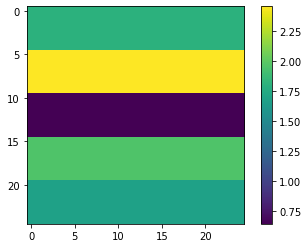

In [22]:
a = 0.5  # lower bound
b = 3  # upper bound
vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)

c = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
    ones[i*5:(i+1)*5] = 1
    c += ones * vec[i]


plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

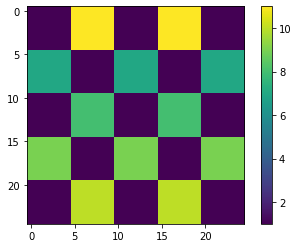

In [23]:
a = 0.5  # lower bound
b = 3  # upper bound
# vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)
vec = [10, 6, 7, 8, 9]

c = torch.ones((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    for j in range(5):
        ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
        ones[i*5:(i+1)*5, j*5:(j+1)*5] = (i+j) % 2  # Alternate between 0 and 1
        c += ones * vec[i]

plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

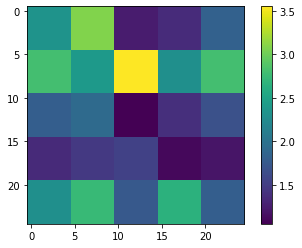

In [24]:
torch.manual_seed(0)  # Set the seed

a = 0.5  # lower bound
b = 3  # upper bound
vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)

c = torch.ones((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    for j in range(5):
        ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
        ones[i*5:(i+1)*5, j*5:(j+1)*5] = torch.rand(1).item()  # Assign a random value
        c += ones * vec[i]

plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

### Define functions to form C values

In [25]:
def create_simple_checkerboard(c_values_tensor):
    c = torch.ones((xysize, xysize), device=device)
        
    for i in range(c_values_tensor.shape[0]):
        for j in range(c_values_tensor.shape[0]):
            ones = torch.zeros((xysize, xysize), device=device)
            ones[i*int(xysize/c_values_tensor.shape[0]):(i+1)*int(xysize/c_values_tensor.shape[0]), j*int(xysize/c_values_tensor.shape[0]):(j+1)*int(xysize/c_values_tensor.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
            c += ones * c_values_tensor[i]
    
    return c

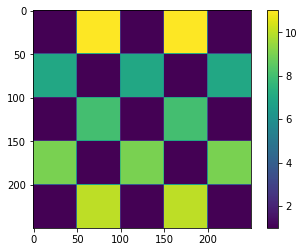

In [26]:
C_tensors_list = [10, 6, 7, 8, 9]
c_tensor = torch.tensor(C_tensors_list, dtype=torch.float32, device=device, requires_grad=True)
c = create_simple_checkerboard(c_tensor)
plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

tensor([5.], device='cuda:0', requires_grad=True)


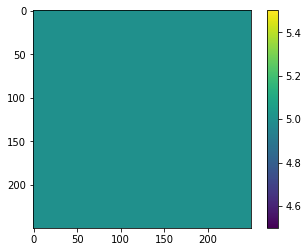

In [27]:
# number_rows = 5
# number_cols = 5
# number_all = number_rows * number_cols

# torch.manual_seed(0)  # Set the seed for reproducibility

# # c_values_tensor = torch.rand(number_all, dtype=torch.float32, device=device, requires_grad=True)
# c_values_tensor = torch.randint(low=0, high=10, size=(number_all,), device=device, dtype=torch.int)
# print(c_values_tensor)

# c = torch.zeros((xysize, xysize), device=device)  # Initialize c with zeros

# for i in range(number_rows):
#     for j in range(number_cols):
#         ones = torch.zeros((xysize, xysize), device=device)
#         ones[i*int(xysize/number_rows):(i+1)*int(xysize/number_rows), j*int(xysize/number_cols):(j+1)*int(xysize/number_cols)] = c_values_tensor[i*number_rows + j]
#         c += ones


number_rows = 1
number_cols = 1
number_all = number_rows * number_cols
torch.manual_seed(0)
c_values_tensor = torch.randint(low=1, high=10, size=(number_all,), device=device, dtype=torch.float32, requires_grad=True)

print(c_values_tensor)

def create_checkerboard(c_values_tensor, xsize, ysize, number_rows, number_cols):
    

    c = torch.zeros((xsize, ysize), device=device)  # Initialize c with zeros

    for i in range(number_rows):
        for j in range(number_cols):
            ones = torch.zeros((xsize, ysize), device=device)
            ones[i*int(xsize/number_rows):(i+1)*int(xsize/number_rows), j*int(ysize/number_cols):(j+1)*int(ysize/number_cols)] = c_values_tensor[i*number_rows + j]
            c += ones

    return c

c = create_checkerboard(c_values_tensor, xysize, xysize, number_rows, number_cols)

plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()



### Data assimilation one timestep - skipping layers

#### Place sensors

In [28]:
xysize = 200

[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [199 197]
 [199 198]
 [199 199]]


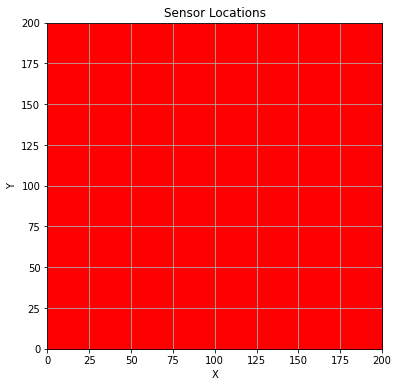

In [29]:
# Set the seed for reproducibility
np.random.seed(0)

# Define the size of your domain
domain_size = (xysize, xysize)  # Example: xysizexxysize grid

n_srata = xysize    #  5
n_sensors = n_srata * n_srata

# Define the number of strata in each dimension
strata_size = (n_srata, n_srata)  # Example: 10x10 strata

# Calculate the size of each stratum
stratum_size = (domain_size[0] // strata_size[0], domain_size[1] // strata_size[1])

# Generate random sensor locations within each stratum
sensor_indices = np.array([
    (np.random.randint(i * stratum_size[0], (i + 1) * stratum_size[0]),
     np.random.randint(j * stratum_size[1], (j + 1) * stratum_size[1]))
    for i in range(strata_size[0])
    for j in range(strata_size[1])
])

# Plot the domain
plt.figure(figsize=(6, 6))
plt.xlim(0, domain_size[0])
plt.ylim(0, domain_size[1])

print(sensor_indices)

# Plot the sensor locations
plt.scatter(sensor_indices[:, 0], sensor_indices[:, 1], color='red')

plt.title('Sensor Locations')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [30]:
# Convert sensor_indices to a PyTorch tensor
sensor_indices = torch.tensor(sensor_indices)

# Separate the x and y coordinates
x_coords = sensor_indices[:, 0]
y_coords = sensor_indices[:, 1]

# Use broadcasting to create a grid of indices
x_coords = x_coords[None, :, None]
y_coords = y_coords[None, :, None]

# Index the output and observation tensors at the sensor locations
# output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
# obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

# Now, output_at_sensors and obs_at_sensors should have the shape (302, 25)
# print(output_at_sensors.shape)
# print(obs_at_sensors.shape)

#### Generate Obs

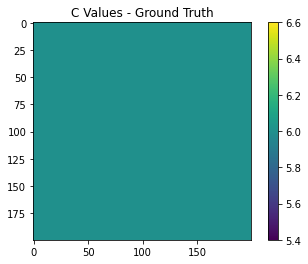

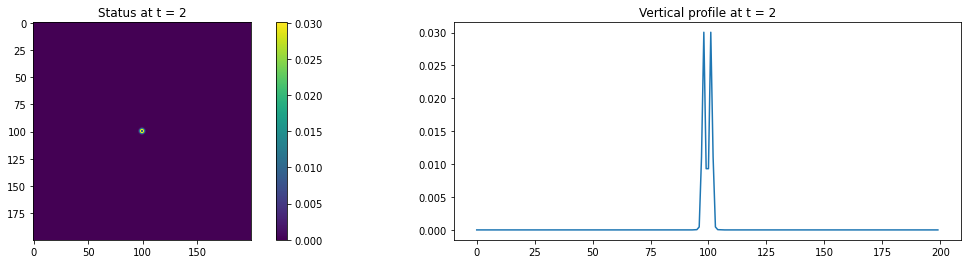

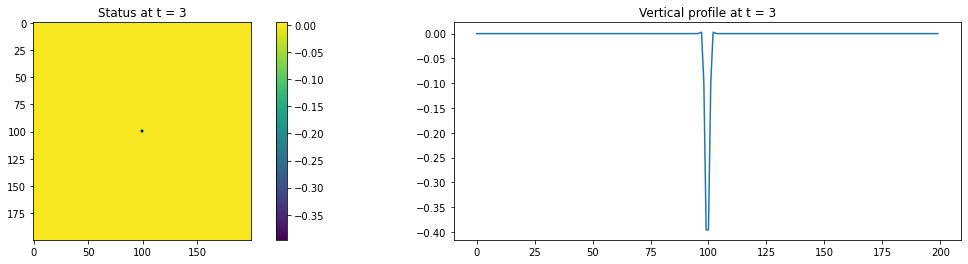

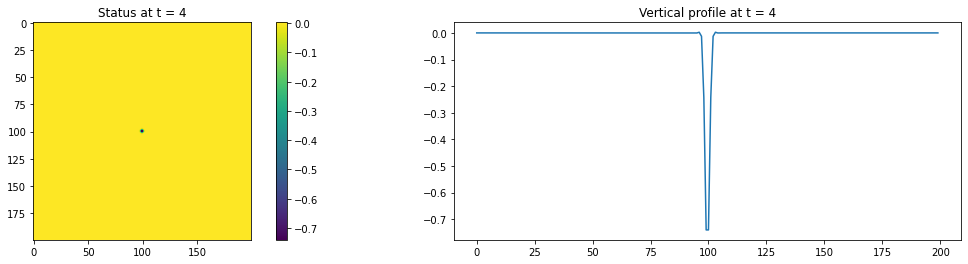

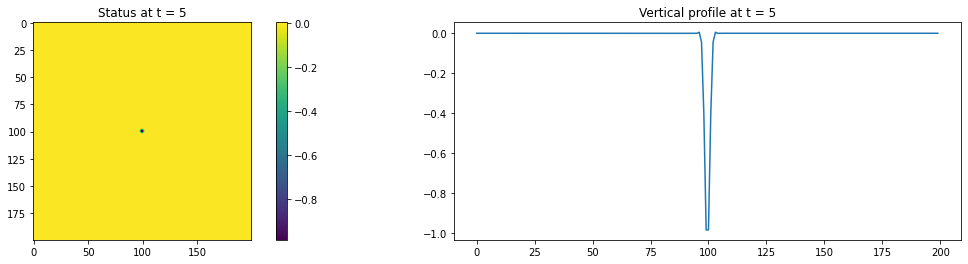

torch.Size([6, 1, 40000, 1])
torch.Size([6, 1, 40000, 1])


In [31]:
timesteps = 4

# Specify the size of the tensor
xysize = xysize
mu_x = 0.5   # 0.5
mu_y = 0.5  # 0.5

# # C values
# C_tensors_list = [10, 6, 7, 8, 9]
# # C_tensors_list = [1, 1, 1, 1, 1]
# c_tensor = torch.tensor(C_tensors_list, dtype=torch.float32, device=device, requires_grad=True)

# nlayers = c_tensor.size(0)

# # Plot C
# c = torch.ones((xysize, xysize), device=device, dtype=torch.float32)

# for i in range(nlayers):
#     for j in range(nlayers):
#         ones = torch.zeros((xysize, xysize), device=device, dtype=torch.float32)
#         ones[i*int(xysize/c_tensor.shape[0]):(i+1)*int(xysize/c_tensor.shape[0]), j*int(xysize/c_tensor.shape[0]):(j+1)*int(xysize/c_tensor.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
#         c += ones * c_tensor[i]  # Use both i and j to index c_tensor

# plt.imshow(c.cpu().detach().numpy(), cmap='viridis')
# plt.colorbar()
# plt.title('C Values - Ground Truth')
# plt.show()

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

# Define a single model
mymodel_obs = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight).to(device)


# Forward pass through the model
output_list = [status_t0_tensor[:,:, x_coords, y_coords], status_t1_tensor[:,:, x_coords, y_coords]]
input1 = status_t1_tensor
input2 = status_t0_tensor


number_rows = 1
number_cols = 1
number_all = number_rows * number_cols
torch.manual_seed(0)
c_values_tensor_obs = torch.randint(low=5, high=15, size=(number_all,), device=device, dtype=torch.float32, requires_grad=True)
c = create_checkerboard(c_values_tensor_obs, xysize, xysize, number_rows, number_cols)

c_show = c
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

for i in range(timesteps):
    with torch.no_grad():
        output = mymodel_obs(input1, input2, c, sigma2)

        output_show = output[:,1:, :, :]

        if (i) % 1 == 0:
            fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side
            # Plot the image on the first subplot
            im = axs[0].imshow(output_show.cpu().detach().numpy()[0][0], cmap='viridis')
            fig.colorbar(im, ax=axs[0])
            axs[0].set_title(f"Status at t = {i+2}")
            # Plot the vertical profile on the second subplot
            vertical_profile = output_show.cpu().detach().numpy()[0][0][xysize//2, :]  # Take the middle row
            axs[1].plot(vertical_profile)
            axs[1].set_title(f"Vertical profile at t = {i+2}")
            plt.show()

        del output_show

    output_list.append(output[:,1:, x_coords, y_coords])
    input1 = output[:,1:, :, :]
    input2 = output[:,0:1, :, :]

    # Delete unnecessary variables
    del output

# Concatenate the output list along the time dimension
output_tensor_obs = torch.cat(output_list, dim=1).squeeze(0)

print(output_tensor_obs.shape)

# for i in range(timesteps):
#     if (i) % 25 == 0:
#         fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

#         # Plot the image on the first subplot
#         im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[i+2], cmap='viridis')
#         fig.colorbar(im, ax=axs[0])
#         axs[0].set_title(f"Status at t = {i+2}")

#         # Plot the vertical profile on the second subplot
#         vertical_profile = output_tensor_obs.cpu().detach().numpy()[i+2][xysize//2, :]  # Take the middle row
#         axs[1].plot(vertical_profile)
#         axs[1].set_title(f"Vertical profile at t = {i+2}")

#         plt.show()

print(output_tensor_obs.shape)

del mymodel_obs

In [32]:
Status_List_stacked_obs = output_tensor_obs.squeeze(0)
print(Status_List_stacked_obs.shape)
xysize*xysize

torch.Size([6, 1, 40000, 1])


40000

In [33]:
# print(Status_List_stacked_obs[:, x_coords, y_coords].shape)

#### One time forward stepping

In [34]:
# Move clone operation outside the loop
# Obs_sensor_3d_array = Status_List_stacked_obs
obs_at_sensors = Status_List_stacked_obs
# print(Obs_sensor_3d_array.shape)
print(obs_at_sensors.shape)

# del Status_List_stacked_obs

torch.Size([6, 1, 40000, 1])


In [35]:
obs_at_sensors = obs_at_sensors.view(timesteps+2, n_srata*n_srata)

In [36]:
# Print the names of all user-defined variables
print([k for k in globals().keys() if not k.startswith('_') and k not in dir(__builtins__)])

['In', 'Out', 'exit', 'quit', 'os', 'np', 'pd', 'time', 'math', 'torch', 'nn', 'F', 'plt', 'wandb', 'is_gpu', 'device', 'current_device', 'device_name', 'courant_number', 'advection_operator_x', 'advection_operator_y', 'data_str', 'data_array', 'tensor', 'xysize', 'x_values', 'y_values', 'x', 'y', 'x_tensor', 'y_tensor', 'sqrt2', 'pi', 'time_tensor_t0', 'time_tensor_t1', 'gaussian2d', 'mu_x', 'mu_y', 'sigma_x', 'sigma_y', 't0_values', 't1_values', 'status_t0', 'status_t1', 'c_np', 'l', 'value_origin_point', 'k', 'sigma2', 'l_over_speed', 'create_reverse_pyramid_tensor', 'pyramid_size', 'inner_square_ratio', 'fig', 'ax', 'ML', 'AI4WaveNeuralNetwork_One_Skipping', 'ConstantCValueLayer', 'AI4WaveNeuralNetwork_Multi_Skipping', 'a', 'b', 'vec', 'c', 'i', 'ones', 'j', 'create_simple_checkerboard', 'C_tensors_list', 'c_tensor', 'number_rows', 'number_cols', 'number_all', 'c_values_tensor', 'create_checkerboard', 'domain_size', 'n_srata', 'n_sensors', 'strata_size', 'stratum_size', 'sensor_ind

In [170]:
print(obs_at_sensors[0,:].shape)

torch.Size([40000])


#### SplitProcess

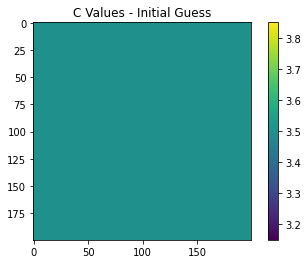

2024-04-22 16:13:04.373725: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


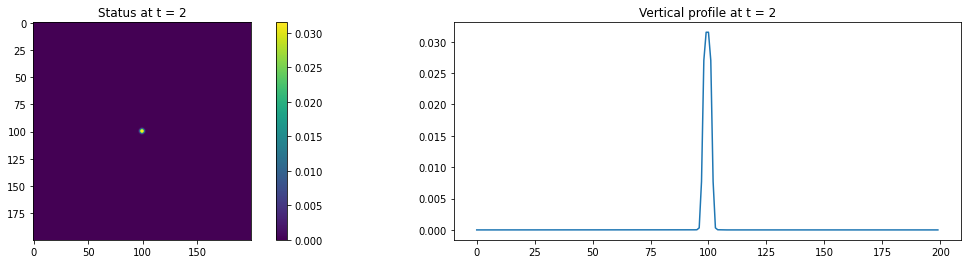

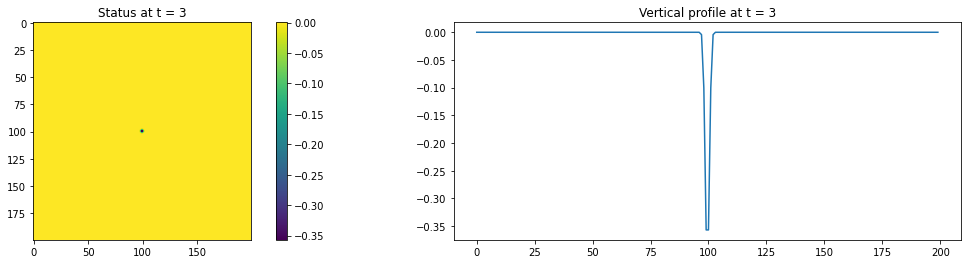

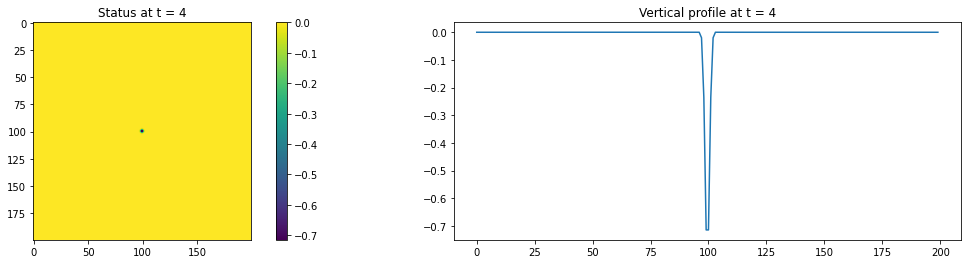

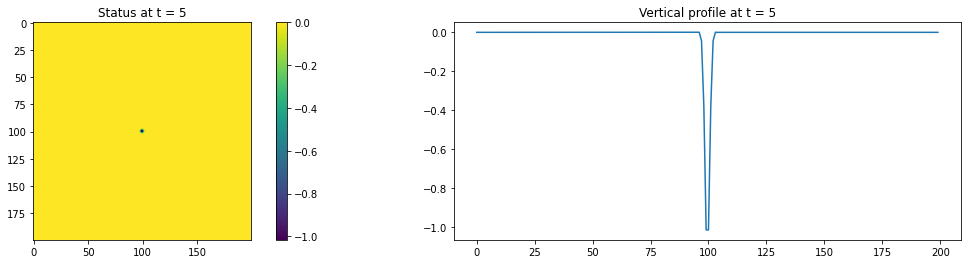

torch.Size([6, 200, 200])


In [171]:
from torch.utils.checkpoint import checkpoint

mse_loss = nn.MSELoss()

# C guess
C_guess_value = 3.5

c_forward1 = torch.tensor([C_guess_value]*number_all, dtype=torch.float32, device=device, requires_grad=False)
c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Initial Guess')
plt.show()

# lr = 0.1
lr = 0.1

# Start a new run
run = wandb.init(project="wave eqn - checkerboard - memory", name = "Only store sensor values {}, guess {}s, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(c_values_tensor_obs, C_guess_value, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y))


losses = []
epochs = 1



# for n in range(epochs):
#     if n % 10 == 0:  # Print every 100 epochs
#         print('epochs:', n)
        
# optimizer.zero_grad()
# with torch.no_grad():
# Forward pass through the model
output_list = [status_t0_tensor[:,:, :,:], status_t1_tensor[:,:, :,:]]
input1 = status_t1_tensor
input2 = status_t0_tensor

# for t in range(timesteps):
#     # print(t)
#     # Use checkpointing for the model
#     # output = checkpoint(model, input1, input2, c, sigma2)
#     output = model(input1, input2, c, sigma2)

#     output_list.append(output[:,1:, :,:])
#     input1 = output[:,1:, :, :]
#     input2 = output[:,0:1, :, :]



# # Concatenate the output list along the time dimension
# output_tensor = torch.cat(output_list, dim=1).squeeze(0)


# output_at_sensors = output_tensor[:, :, :].squeeze()


# # Compute the loss
# loss = mse_loss(output_at_sensors, obs_at_sensors)

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)

for i in range(timesteps):
    with torch.no_grad():

        output = model(input1, input2, c, sigma2)

        output_show = output[:,1:, :, :]

        if (i) % 1 == 0:
            fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side
            # Plot the image on the first subplot
            im = axs[0].imshow(output_show.cpu().detach().numpy()[0][0], cmap='viridis')
            fig.colorbar(im, ax=axs[0])
            axs[0].set_title(f"Status at t = {i+2}")
            # Plot the vertical profile on the second subplot
            vertical_profile = output_show.cpu().detach().numpy()[0][0][xysize//2, :]  # Take the middle row
            axs[1].plot(vertical_profile)
            axs[1].set_title(f"Vertical profile at t = {i+2}")
            plt.show()

        del output_show

    output_list.append(output[:,1:, :,:])
    input1 = output[:,1:, :, :]
    input2 = output[:,0:1, :, :]

    # Delete unnecessary variables
    # del output

# Concatenate the output list along the time dimension
output_tensor = torch.cat(output_list, dim=1).squeeze(0)

print(output_tensor.shape)

In [172]:
C_guess_values = [C_guess_value]*number_all

In [173]:
print(timesteps)

4


In [174]:
print(c_forward1)

for t in range(timesteps):

    input1 = output_tensor[timesteps - i:timesteps - i + 1, :, :].unsqueeze(0)
    input2 = output_tensor[timesteps - i - 1:timesteps - i, :, :].unsqueeze(0)

    print(input1.shape)


    c_forward1 = torch.tensor(C_guess_values, dtype=torch.float32, device=device, requires_grad=True)

    # Use Adam optimizer
    optimizer = torch.optim.Adam([c_forward1], lr)
    # c_values = [c_forward1.tolist()]
    
    # Zero the gradients
    optimizer.zero_grad()

    # Define a single model
    model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

    c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)

    # Forward pass through the model
    output = model(input1, input2, c, sigma2)

    print(output.shape)

    output_at_sensors = output[:, 1:, x_coords, y_coords].flatten()

    obs_at_sensors = output_tensor[t, x_coords, y_coords].flatten()

    print(output_at_sensors.shape)
    print(obs_at_sensors.shape)

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)

    print('t_start')

    # Backpropagation
    loss.backward()

    # Update the weights
    optimizer.step()

    print(c_forward1)

    print('t_end')

C_guess_value = c_forward1[0].item()


tensor([3.5000], device='cuda:0')
torch.Size([1, 1, 200, 200])
torch.Size([1, 2, 200, 200])
torch.Size([40000])
torch.Size([40000])
t_start
tensor([3.4009], device='cuda:0', requires_grad=True)
t_end
torch.Size([1, 1, 200, 200])
torch.Size([1, 2, 200, 200])
torch.Size([40000])
torch.Size([40000])
t_start
tensor([3.4016], device='cuda:0', requires_grad=True)
t_end
torch.Size([1, 1, 200, 200])
torch.Size([1, 2, 200, 200])
torch.Size([40000])
torch.Size([40000])
t_start
tensor([3.5000], device='cuda:0', requires_grad=True)
t_end
torch.Size([1, 1, 200, 200])
torch.Size([1, 2, 200, 200])
torch.Size([40000])
torch.Size([40000])
t_start
tensor([3.5984], device='cuda:0', requires_grad=True)
t_end


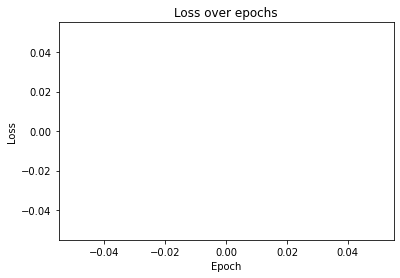

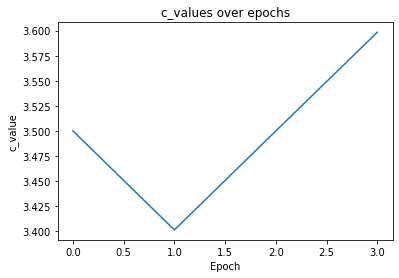

In [175]:
c_values.append(c_forward1.tolist())

# Log the loss and c_value to wandb
log_dict = {"loss": loss.item()}
log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
wandb.log(log_dict)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(c_values)
plt.title('c_values over epochs')
plt.xlabel('Epoch')
plt.ylabel('c_value')
plt.show()

tensor([6.], device='cuda:0', requires_grad=True)


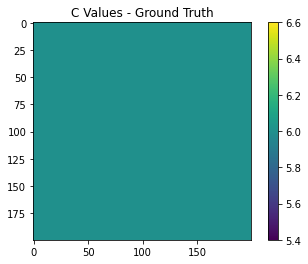

[3.5]


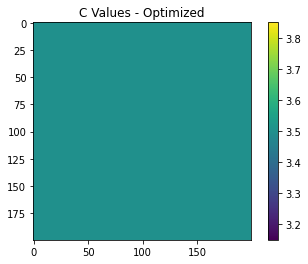

In [154]:
print(c_values_tensor_obs)

c_show = create_checkerboard(c_values_tensor_obs, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimized')
plt.show()

In [138]:
from torchviz import make_dot

# Visualize the computational graph
dot = make_dot(loss, params={'c_values': c_forward1})

dot.render(filename='graph_smallmodel_without_checkpoint_{}timesteps_1Cvalue_Split'.format(timesteps), format='pdf')

'graph_smallmodel_without_checkpoint_2timesteps_1Cvalue_Split.pdf'

#### NoCheckpoint

In [37]:
print(number_all)

1


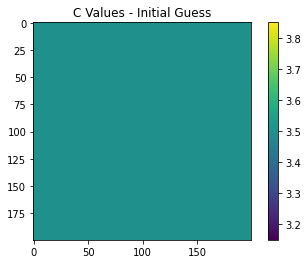

c_value_1,▁
loss,▁
c_value_1,3.58742
loss,0.0


2024-04-23 17:31:30.277760: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


epochs: 0
torch.Size([6, 40000])
torch.Size([6, 40000])
torch.Size([10, 40000])
torch.Size([6, 40000])


/home/dg321/anaconda3/envs/icdss/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([6, 40000])) that is different to the input size (torch.Size([10, 40000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (10) must match the size of tensor b (6) at non-singleton dimension 0

In [57]:
from torch.utils.checkpoint import checkpoint

mse_loss = nn.MSELoss()

# C guess
C_guess_value = 3.5
c_forward1 = torch.tensor([C_guess_value]*number_all, dtype=torch.float32, device=device, requires_grad=True)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Initial Guess')
plt.show()

# lr = 0.1
lr = 0.1

# Start a new run
run = wandb.init(project="wave eqn - checkerboard - memory", name = "Only store sensor values {}, guess {}s, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(c_values_tensor_obs, C_guess_value, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y))

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward1], lr)
c_values = [c_forward1.tolist()]

losses = []
epochs = 100

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

# for n in range(epochs):
#     if n % 10 == 0:  # Print every 100 epochs
#         print('epochs:', n)
        
optimizer.zero_grad()
# with torch.no_grad():
# Forward pass through the model
output_list = [status_t0_tensor[:,:, x_coords, y_coords], status_t1_tensor[:,:, x_coords, y_coords]]
input1 = status_t1_tensor
input2 = status_t0_tensor

c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)

for n in range(epochs):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)

    for t in range(timesteps):
        # print(t)
        # Use checkpointing for the model
        # output = checkpoint(model, input1, input2, c, sigma2)
        output = model(input1, input2, c, sigma2)

        output_list.append(output[:,1:, x_coords, y_coords])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]



    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)


    output_at_sensors = output_tensor[:, :, :].squeeze()

    print(output_at_sensors.shape)
    print(obs_at_sensors.shape)


    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)

    # Backward pass to calculate gradients
    loss.backward(retain_graph=True)
    # loss.backward()

    losses.append(loss.item())

    # optimize C
    optimizer.step()
    c_values.append(c_forward1.tolist())

    # Log the loss and c_value to wandb
    log_dict = {"loss": loss.item()}
    log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
    wandb.log(log_dict)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(c_values)
plt.title('c_values over epochs')
plt.xlabel('Epoch')
plt.ylabel('c_value')
plt.show()




tensor([6.], device='cuda:0', requires_grad=True)


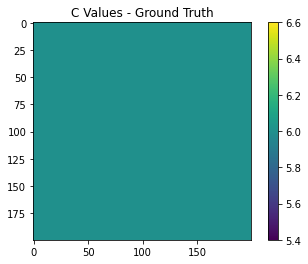

[3.5874228477478027]


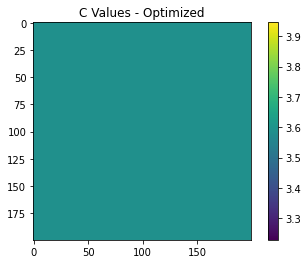

In [40]:
print(c_values_tensor_obs)

c_show = create_checkerboard(c_values_tensor_obs, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimized')
plt.show()

In [101]:
from torchviz import make_dot

# Visualize the computational graph
dot = make_dot(loss, params={'c_values': c_forward1})

dot.render(filename='graph_smallmodel_without_checkpoint_{}timesteps_1Cvalue'.format(timesteps), format='pdf')

'graph_smallmodel_without_checkpoint_1timesteps_1Cvalue.pdf'

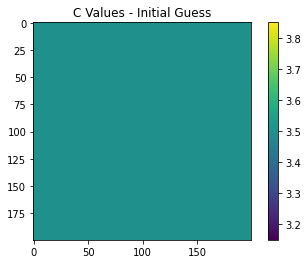

c_value_1,▁█
loss,▁█
c_value_1,3.67058
loss,0.00044


2024-04-23 17:26:26.242697: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


epochs: 0
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3


/home/dg321/anaconda3/envs/icdss/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([6, 40000])) that is different to the input size (torch.Size([40000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3


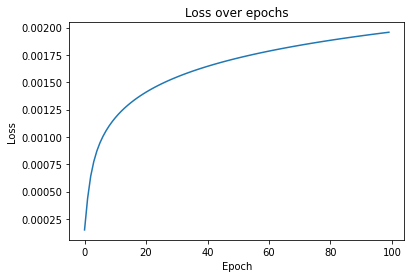

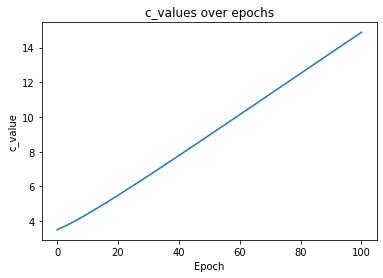

In [52]:
from torch.utils.checkpoint import checkpoint

epochs = 100

mse_loss = nn.MSELoss()

# C guess
C_guess_value = 3.5
c_forward1 = torch.tensor([C_guess_value]*number_all, dtype=torch.float32, device=device, requires_grad=True)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Initial Guess')
plt.show()

# lr = 0.1
lr = 0.1

# Start a new run
run = wandb.init(project="wave eqn - checkerboard - memory", name = "Only store sensor values {}, guess {}s, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(c_values_tensor_obs, C_guess_value, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y))

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward1], lr)
c_values = [c_forward1.tolist()]

losses = []
# epochs = 1

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

input1 = status_t1_tensor
input2 = status_t0_tensor

c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)



for n in range(epochs):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)

    for t in range(timesteps):
        print(t)

        optimizer.zero_grad()

        output = model(input1, input2, c, sigma2)

        output_at_sensors = output[:,1:, x_coords, y_coords].squeeze()

        # obs_at_sensors = obs_at_sensors[t, :, :].squeeze()
        # obs_at_sensors = output_tensor[t, x_coords, y_coords].flatten()

        # print(output_at_sensors.shape)
        # print(obs_at_sensors.shape)

        # Compute the loss
        loss = mse_loss(output_at_sensors, obs_at_sensors)

        # Backward pass to calculate gradients
        loss.backward(retain_graph=True)

        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]

        # optimize C
    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss.item())
    c_values.append(c_forward1.tolist())


    # Log the loss and c_value to wandb
    log_dict = {"loss": loss.item()}
    log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
    wandb.log(log_dict)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(c_values)
plt.title('c_values over epochs')
plt.xlabel('Epoch')
plt.ylabel('c_value')
plt.show()

tensor([6.], device='cuda:0', requires_grad=True)


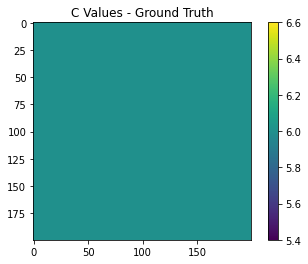

[3.670578718185425]


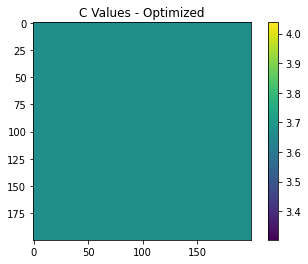

In [51]:
print(c_values_tensor_obs)

c_show = create_checkerboard(c_values_tensor_obs, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimized')
plt.show()

#### Checkpoint

In [ ]:
def forward_process(model, input1, input2, c, sigma2, timesteps, x_coords, y_coords):
    output_list = [input1[:,:, x_coords, y_coords], input2[:,:, x_coords, y_coords]]
    for t in range(timesteps):
        print(t)
        # output = model(input1, input2, c, sigma2)
        output = checkpoint(model, input1, input2, c, sigma2)
        output_list.append(output[:,1:, x_coords, y_coords])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)
    output_at_sensors = output_tensor[:, :, :].squeeze()
    return output_at_sensors

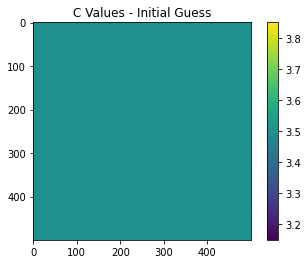

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guodh5 (guodh). Use `wandb login --relogin` to force relogin
2024-04-19 11:53:21.911538: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
import gc

from torch.utils.checkpoint import checkpoint

mse_loss = nn.MSELoss()

# C guess
C_guess_value = 3.5
c_forward1 = torch.tensor([C_guess_value]*number_all, dtype=torch.float32, device=device, requires_grad=True)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Initial Guess')
plt.show()

# lr = 0.1
lr = 0.1

# Start a new run
run = wandb.init(project="wave eqn - checkerboard - memory", name = "Only store sensor values {}, guess {}s, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(c_values_tensor_obs, C_guess_value, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y))

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward1], lr)
c_values = [c_forward1.tolist()]

losses = []
epochs = 300

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

# for n in range(1):
    # if n % 1 == 0:  # Print every 100 epochs
    #     print('epochs:', n)
        
optimizer.zero_grad()
c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
output_at_sensors = checkpoint(forward_process, model, status_t1_tensor, status_t0_tensor, c, sigma2, timesteps, x_coords, y_coords)
loss = mse_loss(output_at_sensors, obs_at_sensors)
print('finish foward process')


In [ ]:
loss.backward(retain_graph=True)
print('finish backward')

losses.append(loss.item())





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# optimize C
optimizer.step()
c_values.append(c_forward1.tolist())

# Log the loss and c_value to wandb
log_dict = {"loss": loss.item()}
log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
wandb.log(log_dict)

tensor([3.5989, 3.5997, 3.5998, 3.5997, 3.5994, 3.5997, 3.5998, 3.5999, 3.5998,
        3.5997, 3.5998, 3.5999, 3.6000, 3.5999, 3.5998, 3.5997, 3.5998, 3.5999,
        3.5998, 3.5997, 3.5990, 3.5997, 3.5998, 3.5997, 3.5992],
       device='cuda:0', requires_grad=True)


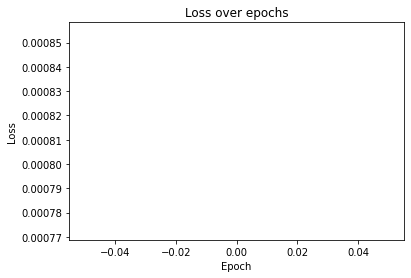

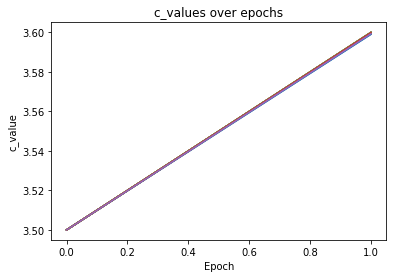

In [ ]:
# Manually call the garbage collector
gc.collect()

print(c_forward1)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(c_values)
plt.title('c_values over epochs')
plt.xlabel('Epoch')
plt.ylabel('c_value')
plt.show()

tensor([ 6., 12.,  6.,  7.,  8.,  9.,  8.,  8.,  7.,  8.,  5., 12., 13.,  9.,
        13., 13.,  9.,  6.,  7.,  6.,  7., 12.,  6., 10.,  9.],
       device='cuda:0', requires_grad=True)


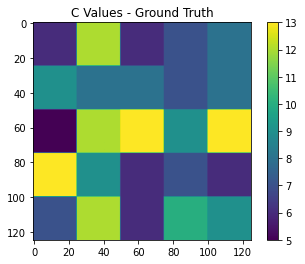

[6.000033378601074, 11.999958038330078, 5.999909400939941, 7.000201225280762, 7.999980449676514, 8.999967575073242, 8.000056266784668, 8.000123977661133, 6.999964237213135, 8.000015258789062, 4.999992847442627, 12.000110626220703, 12.999832153320312, 9.000070571899414, 13.000032424926758, 13.00008487701416, 9.000016212463379, 6.000040054321289, 7.000024795532227, 5.999964237213135, 7.000065326690674, 11.999906539916992, 6.000018119812012, 10.00001335144043, 8.999985694885254]


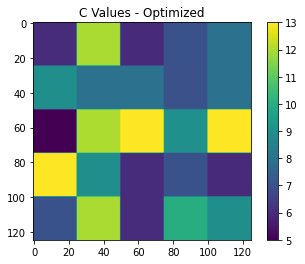

In [ ]:
print(c_values_tensor_obs)

c_show = create_checkerboard(c_values_tensor_obs, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimized')
plt.show()

In [ ]:
2261- 1649

612

In [ ]:
1649 - 1289

360

In [ ]:
4067-2553

1514

In [ ]:
2553-1649

904

In [ ]:
2377 - 2249

128

#### Visualise computational graph

In [ ]:
from torch.utils.checkpoint import checkpoint

mse_loss = nn.MSELoss()

# C guess
C_guess_value = 3.5
c_forward1 = torch.tensor([C_guess_value]*number_all, dtype=torch.float32, device=device, requires_grad=True)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Initial Guess')
plt.show()

# lr = 0.1
lr = 0.1

# Start a new run
run = wandb.init(project="wave eqn - checkerboard - memory", name = "Only store sensor values {}, guess {}s, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(c_values_tensor_obs, C_guess_value, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y))

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward1], lr)
c_values = [c_forward1.tolist()]

losses = []
epochs = 300

In [ ]:
mse_loss = nn.MSELoss()

# C guess
C_guess_value = 3.5
c_forward1 = torch.tensor([C_guess_value]*number_all, dtype=torch.float32, device=device, requires_grad=True)

# lr = 0.1
lr = 0.1

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward1], lr)
c_values = [c_forward1.tolist()]

losses = []

# Move clone operation outside the loop
Obs_sensor_3d_array = obs_at_sensors.clone()

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

for param in model.parameters():
    param.requires_grad = False

for n in range(1):
    if n % 10 == 0:  # Print every 100 epochs
        print('epochs:', n)
        
    optimizer.zero_grad()
    # with torch.no_grad():
    # Forward pass through the model
    output_list = [status_t0_tensor[:,:, x_coords, y_coords], status_t1_tensor[:,:, x_coords, y_coords]]
    input1 = status_t1_tensor
    input2 = status_t0_tensor

    c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)

    for t in range(timesteps):
        # print(t)
        # Use checkpointing for the model
        # output = checkpoint(model, input1, input2, c, sigma2)
        output = model(input1, input2, c, sigma2)

        output_list.append(output[:,1:, x_coords, y_coords])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]

        # Delete unnecessary variables
        # del output

    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)
    # del output_list

    output_at_sensors = output_tensor[:, :, :].squeeze()
    # del output_tensor

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)
    # del output_at_sensors, obs_at_sensors

    # Backward pass to calculate gradients
    loss.backward(retain_graph=True)
    # loss.backward()

    print(loss.item())

epochs: 0
0.0007247882895171642


In [ ]:
from torchviz import make_dot

# Visualize the computational graph
dot = make_dot(loss, params={'c_values': c_forward1})

# dot.render(filename='graph_smallmodel_without_checkpoint', format='pdf')